# MadMiner physics tutorial (part 2A)

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this second part of the tutorial, we'll generate events and extract the observables and weights from them. You have two options: In this notebook we'll do this at parton level, in the alternative part 2b we use Delphes.

## 0. Preparations

Before you execute this notebook, make sure you have a running installation of MadGraph.

In [1]:
import os
import logging
import numpy as np

from madminer.core import MadMiner
from madminer.lhe import LHEReader
from madminer.sampling import combine_and_shuffle
from madminer.plotting import plot_distributions
from particle import Particle

In [2]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

In [3]:
#mg_dir = os.getenv("/Users/zimermma/work/MG5_aMC_v3_1_0/")
mg_dir="/nfs/dust/cms/user/zimermma/madminer/MG5_aMC_v2_8_3_2"

## 1. Generate events

Please enter here the environment variable pointing to your MG5 installation folder.

Let's load our setup:

In [4]:
miner = MadMiner()
miner.load("data/setup-Jonas-test.h5")

12:20 madminer.utils.inter ERROR   HDF5 file does not contain nuisance parameters information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain finite difference information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain observables information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain sample summary information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain sample information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain systematic information
12:20 madminer.core.madmin INFO    Found 2 parameters:
12:20 madminer.core.madmin INFO       ctG (LHA: DIM6 16, Power: 2, Range: (-2.0, 2.0)Label: None)
12:20 madminer.core.madmin INFO       ctq8 (LHA: DIM6 55, Power: 2, Range: (-5.0, 5.0)Label: None)
12:20 madminer.core.madmin INFO    Found 6 benchmarks:
12:20 madminer.core.madmin INFO       sm: ctG = 0.00e+00, ctq8 = 0.00e+00
12:20 madminer.core.madmin INFO       ctG: ctG = 2.00, ctq8 = 0.00e+00
12:20 madminer.core.m

In a next step, MadMiner starts MadGraph to generate events and calculate the weights. You can use `run()` or `run_multiple()`; the latter allows to generate different runs with different run cards and optimizing the phase space for different benchmark points. 

In either case, you have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card. Log files in the `log_directory` folder collect the MadGraph output and are important for debugging.

The `sample_benchmark` (or in the case of `run_all`, `sample_benchmarks`) option can be used to specify which benchmark should be used for sampling, i.e. for which benchmark point the phase space is optimized. If you just use one benchmark, reweighting to far-away points in parameter space can lead to large event weights and thus large statistical fluctuations. It is therefore often a good idea to combine a lot of events at the "reference hypothesis" (for us the SM) and smaller samples from other benchmarks that span the parameter space.


In [ ]:
miner.run(
    sample_benchmark="sm",
    mg_directory=mg_dir,
    mg_process_directory="./mg_processes/signal1",
    proc_card_file="cards/proc_card_signal.dat",
    param_card_template_file="cards/param_card_template.dat",
    run_card_file="cards/run_card_signal_large.dat",
    log_directory="logs/signal",
    python_executable="python3",
)

In [6]:
additional_benchmarks = ["ctG", "neg_ctG", "ctq8", "neg_ctq8"]

In [7]:
miner.run_multiple(
    sample_benchmarks=additional_benchmarks,
    mg_directory=mg_dir,
    mg_process_directory="./mg_processes/signal2",
    proc_card_file="cards/proc_card_signal.dat",
    param_card_template_file="cards/param_card_template.dat",
    run_card_files=["cards/run_card_signal_small.dat"],
    log_directory="logs/signal",
    python_executable="python3",
)

14:37 madminer.core.madmin INFO    Adding python3 bin folder to PATH
14:37 madminer.core.madmin INFO    Using Python executable /nfs/dust/cms/user/zimermma/miniconda3/envs/madminer/bin/python3
14:37 madminer.utils.inter INFO    Generating MadGraph process folder from cards/proc_card_signal.dat at ./mg_processes/signal2
14:37 madminer.utils.inter INFO    Calling MadGraph: export PATH=/nfs/dust/cms/user/zimermma/miniconda3/envs/madminer/bin:$PATH; python3 /nfs/dust/cms/user/zimermma/madminer/MG5_aMC_v2_8_3_2/bin/mg5_aMC /tmp/generate.mg5
14:38 madminer.core.madmin INFO    Run 0
14:38 madminer.core.madmin INFO      Sampling from benchmark: ctG
14:38 madminer.core.madmin INFO      Original run card:       cards/run_card_signal_small.dat
14:38 madminer.core.madmin INFO      Original Pythia8 card:   None
14:38 madminer.core.madmin INFO      Original config card:    None
14:38 madminer.core.madmin INFO      Copied run card:         madminer/cards/run_card_0.dat
14:38 madminer.core.madmin INFO

This will take a moment -- time for a coffee break!

After running any event generation through MadMiner, you should check whether the run succeeded: are the usual output files there, do the log files show any error messages? MadMiner does not (yet) perform any explicit checks, and if something went wrong in the event generation, it will only notice later when trying to load the event files.

### Backgrounds

We can also easily add other processes like backgrounds. An important option is the `is_background` keyword, which should be used for processes that do *not* depend on the parameters theta. `is_background=True` will disable the reweighting and re-use the same weights for all cross sections.

To reduce the runtime of the notebook, the background part is commented out here. Feel free to activate it and let it run during a lunch break.

In [23]:
#miner.run(
#    is_background=True,
#    sample_benchmark='sm',
#    mg_directory=mg_dir,
#    mg_process_directory='./mg_processes/background',
#    proc_card_file='cards/proc_card_background.dat',
#    param_card_template_file='cards/param_card_template.dat',
#    run_card_file='cards/run_card_background.dat',
#    log_directory='logs/background',
#)


Finally, note that both `MadMiner.run()` and `MadMiner.run_multiple()` have a `only_create_script` keyword. If that is set to True, MadMiner will not start the event generation directly, but prepare folders with all the right settings and ready-to-run bash scripts. This might make it much easier to generate Events on a high-performance computing system. 

## 2. Prepare analysis of the LHE samples

The `madminer.lhe` submodule allows us to extract observables directly from the parton-level LHE samples, including an approximate description of the detector response with smearing functions. The central object is an instance of the `LHEProcessor` class, which has to be initialized with a MadMiner file:

In [5]:
lhe = LHEReader("data/setup-Jonas-test.h5")
import h5py
import numpy as np
setupfile = "data/setup-Jonas-test.h5"
f = h5py.File(setupfile)
f.keys()
for key in f.keys():
    print("--------------------------------------------------------------")
    print(key+":")
    for string in np.array(f[key]):
        print("  ",string +":", np.array(f[key][string]))
    print

12:07 madminer.utils.inter ERROR   HDF5 file does not contain nuisance parameters information
12:07 madminer.utils.inter ERROR   HDF5 file does not contain finite difference information
12:07 madminer.utils.inter ERROR   HDF5 file does not contain observables information
12:07 madminer.utils.inter ERROR   HDF5 file does not contain sample summary information
12:07 madminer.utils.inter ERROR   HDF5 file does not contain sample information
12:07 madminer.utils.inter ERROR   HDF5 file does not contain systematic information


--------------------------------------------------------------
benchmarks:
   is_nuisance: [0 0 0 0 0 0]
   is_reference: [0 0 0 0 0 0]
   names: [b'sm' b'ctG' b'neg_ctG' b'ctq8' b'neg_ctq8' b'morphing_basis_vector_5']
   values: [[ 0.          0.        ]
 [ 2.          0.        ]
 [-2.          0.        ]
 [ 0.          5.        ]
 [ 0.         -5.        ]
 [ 1.95544762 -4.89358365]]
--------------------------------------------------------------
morphing:
   components: [[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [2 0]]
   morphing_matrix: [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.16333634e-18  0.00000000e+00  0.00000000e+00  1.00000000e-01
  -1.00000000e-01  0.00000000e+00]
 [-4.00000000e-02  0.00000000e+00  0.00000000e+00  2.00000000e-02
   2.00000000e-02  0.00000000e+00]
 [ 0.00000000e+00  2.50000000e-01 -2.50000000e-01  0.00000000e+00
  -0.00000000e+00  0.00000000e+00]
 [-9.54975752e-02  1.01036579e-01 -1.13803039e-03 -1

After creating the `LHEReader` object, one can add a number of event samples (the output of running MadGraph in step 1) with the `add_sample()` function.

In addition, you have to provide the information which sample was generated from which benchmark with the `sampled_from_benchmark` keyword, and set `is_background=True` for all background samples.

In [5]:

lhe = LHEReader("data/setup-Jonas-test.h5")
lhe.add_sample(
    lhe_filename="mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz",
    sampled_from_benchmark="sm",
    is_background=False,
    k_factor=1.0,
)
for i, benchmark in enumerate(additional_benchmarks):
    lhe.add_sample(
        lhe_filename="mg_processes/signal2/Events/run_0{}/unweighted_events.lhe.gz".format(i + 1),
        sampled_from_benchmark=benchmark,
        is_background=False,
        k_factor=1.0,
    )


#lhe.add_sample(
#    lhe_filename='mg_processes/background/Events/run_01/unweighted_events.lhe.gz',
#    sampled_from_benchmark='sm',
#    is_background=True,
#    k_factor=1.0,
#)


12:20 madminer.utils.inter ERROR   HDF5 file does not contain nuisance parameters information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain finite difference information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain observables information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain sample summary information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain sample information
12:20 madminer.utils.inter ERROR   HDF5 file does not contain systematic information
12:20 madminer.lhe.lhe_rea DEBUG   Adding event sample mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz


NameError: name 'additional_benchmarks' is not defined

## 3. Smearing functions to model the detector response

Now we have to define the smearing functions that are used (in lieu of a proper shower and detector simulation). Here we will assume a simple 10% uncertainty on the jet energy measurements and a $\pm 0.1$ smearing for jet $\eta$ and $\phi$. The transverse momenta of the jets are then derived from the smeared energy and the on-shell condition for the quarks (this is what `pt_resolution_abs=None` does). The photons from the Higgs are assumed to be measured perfectly (otherwise we'd have to call `set_smearing` another time with `pdgis=[22]`).

In [28]:
# Partons giving rise to jets
particles = [
    *Particle.findall(lambda p: p.pdgid.is_quark),
    *Particle.findall(pdg_name="g"),
]

lhe.set_smearing(
    pdgids=[int(p.pdgid) for p in particles],
    energy_resolution_abs=0.0,
    energy_resolution_rel=0.1,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.1,
    eta_resolution_rel=0.0,
    phi_resolution_abs=0.1,
    phi_resolution_rel=0.0,
)

# Partons giving rise to jets
top = [p for p in particles if p.pdgid==6]
print(top[0])

t


In addition, we can define noise that only affects MET. This adds Gaussian noise with mean 0 and std `abs_ + rel * HT` to MET_x and MET_y separately.

In [7]:
lhe.set_met_noise(abs_=10.0, rel=0.05)

In [8]:
tops = [lambda p: p.pdgid==6 for p in particles]
print(tops)
atops = [ *Particle.findall(pdgid=-6)]
print(atops[0])

[<function <listcomp>.<lambda> at 0x7fd596610ef0>, <function <listcomp>.<lambda> at 0x7fd596610f80>, <function <listcomp>.<lambda> at 0x7fd59662a050>, <function <listcomp>.<lambda> at 0x7fd59662a0e0>, <function <listcomp>.<lambda> at 0x7fd59662a170>, <function <listcomp>.<lambda> at 0x7fd59662a200>, <function <listcomp>.<lambda> at 0x7fd59662a290>, <function <listcomp>.<lambda> at 0x7fd59662a320>, <function <listcomp>.<lambda> at 0x7fd59662a3b0>, <function <listcomp>.<lambda> at 0x7fd59662a440>, <function <listcomp>.<lambda> at 0x7fd59662a4d0>, <function <listcomp>.<lambda> at 0x7fd59662a560>, <function <listcomp>.<lambda> at 0x7fd59662a5f0>]
t~


In [9]:
lhe.add_observable(

SyntaxError: unexpected EOF while parsing (2066863071.py, line 1)

01:31 madminer.utils.inter ERROR   HDF5 file does not contain nuisance parameters information
01:31 madminer.utils.inter ERROR   HDF5 file does not contain finite difference information
01:31 madminer.utils.inter ERROR   HDF5 file does not contain observables information
01:31 madminer.utils.inter ERROR   HDF5 file does not contain sample summary information
01:31 madminer.utils.inter ERROR   HDF5 file does not contain sample information
01:31 madminer.utils.inter ERROR   HDF5 file does not contain systematic information
01:31 madminer.lhe.lhe_rea DEBUG   Adding event sample mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz
01:31 madminer.lhe.lhe_rea DEBUG   Adding optional observable chel defined through external function with default None
01:31 madminer.lhe.lhe_rea DEBUG   Adding required observable pt_e1 = l[0].pt
01:31 madminer.lhe.lhe_rea DEBUG   Adding required observable mass_p0 = p[0].m
01:31 madminer.lhe.lhe_rea DEBUG   Adding optional observable ttbar_boost = -(p[10

lcos_phi:  -0.24967734383694765
lcos_phi:  0.7740576002152391
lcos_phi:  0.9832044465694763
lcos_phi:  0.7005897548949858
lcos_phi:  -0.3993640792166597
lcos_phi:  0.24000647599135091
lcos_phi:  0.21770850975129766
lcos_phi:  0.8082327581165882
lcos_phi:  -0.6205287703801691


01:31 madminer.utils.inter DEBUG   Event 10 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter DEBUG   Event 11 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter DEBUG   Event 12 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter DEBUG   Event 13 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter DEBUG   Event 14 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter DEBUG   Event 15 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter DEBUG   Event 16 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter DEBUG   Event 17 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter DEBUG   Event 18 passes observations, passes cuts, passes efficiencies -> passes
01:31 madminer.utils.inter D

lcos_phi:  0.34552659095556565
lcos_phi:  -0.14928607975030053
lcos_phi:  0.8781054679071231
lcos_phi:  0.7818085361246837
lcos_phi:  0.7976085916306606
lcos_phi:  -0.1607439682781871
lcos_phi:  -0.15569842554332328
lcos_phi:  0.8746823916441091
lcos_phi:  -0.5207470071496063
lcos_phi:  0.520174660209742
lcos_phi:  0.2221410321947063
lcos_phi:  -0.22740645719826028
lcos_phi:  0.8137726896657645
lcos_phi:  0.4721896094881216
lcos_phi:  -0.11566088136560598
lcos_phi:  0.299133758317094
lcos_phi:  -0.931358954234489
lcos_phi:  0.8869562472352163
lcos_phi:  -0.7950683833857397
lcos_phi:  0.3991097583494636
lcos_phi:  -0.5368940805650232
lcos_phi:  0.6771673374140882
lcos_phi:  -0.06262740721346985
lcos_phi:  0.6825633855290613
lcos_phi:  -0.28590315755129836
lcos_phi:  0.8376828406428262
lcos_phi:  0.06395148430481011
lcos_phi:  0.8643233293527256
lcos_phi:  -0.660516988283992
lcos_phi:  -0.47069070576816424
lcos_phi:  -0.2284522206273738
lcos_phi:  0.2064324659069738
lcos_phi:  -0.8765557

01:31 madminer.utils.inter INFO      Break at event 100/50000
01:31 madminer.lhe.lhe_rea DEBUG   Found weights ['sm', 'ctG', 'neg_ctG', 'ctq8', 'neg_ctq8', 'morphing_basis_vector_5'] in LHE file
01:31 madminer.lhe.lhe_rea DEBUG   Found 99 events
01:31 madminer.lhe.lhe_rea DEBUG   Found 99 events
01:31 madminer.lhe.lhe_rea INFO    Analysed number of events per sampling benchmark:
01:31 madminer.lhe.lhe_rea INFO      99 from sm
01:31 madminer.lhe.lhe_rea DEBUG   Loading HDF5 data from data/setup-Jonas-test.h5 and saving file to data/lhe_data_Jonas.h5
01:31 madminer.lhe.lhe_rea DEBUG   Weight names: ['sm', 'ctG', 'neg_ctG', 'ctq8', 'neg_ctq8', 'morphing_basis_vector_5']
01:31 madminer.utils.inter DEBUG   Benchmark ctG already in the list of benchmarks
01:31 madminer.utils.inter DEBUG   Benchmark ctq8 already in the list of benchmarks
01:31 madminer.utils.inter DEBUG   Benchmark morphing_basis_vector_5 already in the list of benchmarks
01:31 madminer.utils.inter DEBUG   Benchmark neg_ctG a

lcos_phi:  -0.730587005547092


01:31 madminer.analysis.da INFO      0 signal events sampled from benchmark morphing_basis_vector_5
01:31 madminer.analysis.da INFO    Found morphing setup with 6 components
01:31 madminer.analysis.da INFO    Did not find nuisance morphing setup
01:31 madminer.plotting.di DEBUG   Observable indices: [0, 1, 2, 3]
01:31 madminer.plotting.di DEBUG   Calculated 2 theta matrices
01:31 madminer.analysis.da DEBUG   Sampling benchmark closest to None: None
01:31 madminer.analysis.da DEBUG   Events per benchmark: [99.  0.  0.  0.  0.  0.]
01:31 madminer.plotting.di DEBUG   Loaded raw data with shapes (99, 4), (99, 6)
01:31 madminer.analysis.da DEBUG   Sampling benchmark closest to [0. 0.]: 0
01:31 madminer.analysis.da DEBUG   Sampling benchmark closest to [10.  0.]: 0
01:31 madminer.plotting.di DEBUG   Plotting panel 0: observable 0, label chel
01:31 madminer.plotting.di DEBUG   Ranges for observable chel: min = [-0.9891831128258269, -0.9891831128258269], max = [0.9832044465694763, 0.9832044465

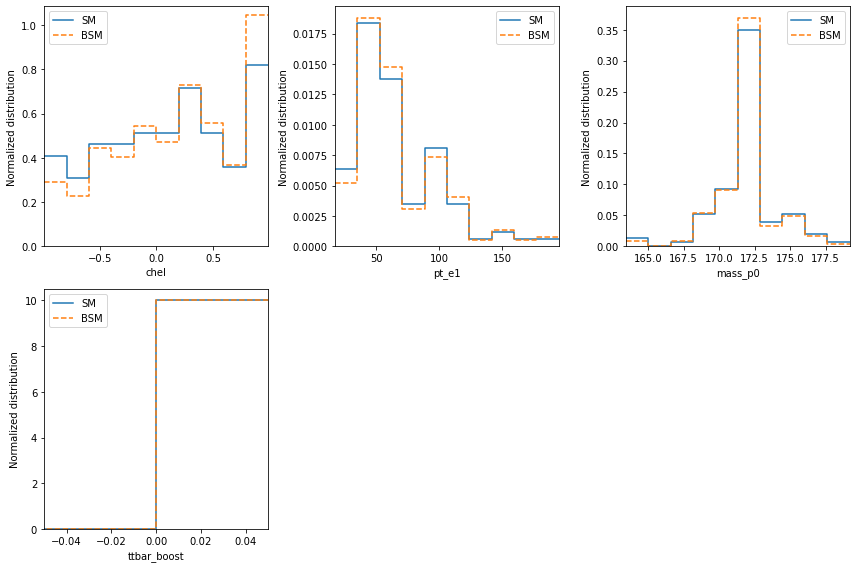

In [6]:
import os
import logging
import numpy as np

from madminer.core import MadMiner
from madminer.lhe import LHEReader
from madminer.sampling import combine_and_shuffle
from madminer.plotting import plot_distributions
from particle import Particle

# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)
        
lhe = LHEReader("data/setup-Jonas-test.h5")
lhe.add_sample(
    lhe_filename="mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz",
    sampled_from_benchmark="sm",
    is_background=False,
    k_factor=1.0,
)
# Partons giving rise to jets
particles = [
    *Particle.findall(lambda p: p.pdgid.is_quark),
    *Particle.findall(pdg_name="g"),
]

lhe.set_smearing(
    pdgids=[int(p.pdgid) for p in particles],
    energy_resolution_abs=0.0,
    energy_resolution_rel=0.1,
    pt_resolution_abs=None,
    pt_resolution_rel=None,
    eta_resolution_abs=0.1,
    eta_resolution_rel=0.0,
    phi_resolution_abs=0.1,
    phi_resolution_rel=0.0,
)

#Prescription to select tops and leptons

def chel(p,l,a,j,met):
    top = [top for top in p if top.pdgid==6][0]
    antitop = [top for top in p if top.pdgid==-6][0]
    lep = [lep for lep in l if lep.pdgid>0][0]
    lepbar = [lep for lep in l if lep.pdgid<0][0]
    #Boosting to the ttbar frame
    ttbar=top+antitop
    #tt_boost=-1*ttbar.to_beta3()
    top_ZMFtt = top.boostCM_of(ttbar)
    antitop_ZMFtt = antitop.boostCM_of(ttbar)
    lep_ZMFtt = lep.boostCM_of(ttbar)
    lepbar_ZMFtt = lepbar.boostCM_of(ttbar)
    #Boosting leptons to their helicity frame
    #t_boost = -1*top_ZMFtt.to_beta3()
    #tbar_boost = -1*antitop_ZMFtt.to_beta3()
    lepbar_ZMFt = lepbar_ZMFtt.boostCM_of(top_ZMFtt).to_Vector3D()
    lep_ZMFtbar = lep_ZMFtt.boostCM_of(antitop_ZMFtt).to_Vector3D()
    mag_lepbar_ZMFt = lepbar_ZMFt.mag
    mag_lep_ZMFtbar = lep_ZMFtbar.mag
    cos_phi=lepbar_ZMFt.dot(lep_ZMFtbar)/(mag_lepbar_ZMFt*mag_lep_ZMFtbar)
    print("lcos_phi: ", cos_phi)
    return cos_phi
#ttbar=f"({t}+{tbar})"
#def lep():
#    return "[lep for lep in l if lep.pdgid>0][0]"

#def lepbar():
#    return "[lep for lep in l if lep.pdgid<0][0]"
#t="[top for top in p if top.pdgid==6][0]"
#tbar="[top for top in p if top.pdgid==-6][0]"
#lep="[lep for lep in l if lep.pdgid>0][0]"
#lepbar="[lep for lep in l if lep.pdgid<0][0]"

#Prescription to boost to the ttbar system
#def tt_boost():
#    return f"-1 * ({t()}+{tbar()}).to_beta3()" 

#def t_ZMFtt():
#    return f"{t()}.boost({tt_boost()})"

#def tbar_ZMFtt():
#    return f"{tbar()}.boost({tt_boost()})"

#def lep_ZMFtt():
#    return f"{lep()}.boost({tt_boost()})"

#def lepbar_ZMFtt():
#    return f"{lepbar()}).boost({tt_boost()})"
#tt_boost=f"-1*({t}+{tbar}).to_beta3()" #finds the beta vector for boosting to the ttbar system
#t_ZMFtt=f"({t}).boost({tt_boost})"
#tbar_ZMFtt=f"({tbar}).boost({tt_boost})"
#lep_ZMFtt = f"({lep}).boost({tt_boost})"
#lepbar_ZMFtt = f"({lepbar}).boost({tt_boost})"

#now prescrition to boost leptons to their helicity frame
#def t_boost():
#    return f"-1 * ({t_ZMFtt()}).to_beta3()"

#def tbar_boost():
#    return f"- 1 * ({tbar_ZMFtt()}).to_beta3()"

#def lep_ZMFtbar():
#    return f"{lep_ZMFtt()}).boost({t_boost()})"

#def lepbar_ZMFt():
#    return f"{lepbar_ZMFtt()}).boost({t_boost()})"
#t_boost = f"-1*({t_ZMFtt}).to_beta3()"
#tbar_boost = f"-1*({tbar_ZMFtt}).to_beta3()"
#lep_ZMFtbar = f"({lep_ZMFtt}).boost({tbar_boost})"
#lepbar_ZMFt = f"{lepbar_ZMFtt}.boost({t_boost})"

#spin observables
#def chel():
#    return f"{lep_ZMFtbar}.dot({lepbar_ZMFt})/({lep_ZMFtbar}.rho*{lep_ZMFtbar}.rho)"

def pt_lepbar_ZMFt():
    return compile(f"{lep_ZMFtbar}.pt","<string>","eval")
#chel=f"{lep_ZMFtbar}.dot({lepbar_ZMFt})/({lep_ZMFtbar}.rho*{lep_ZMFtbar}.rho)"

#lhe.add_default_observables(n_leptons_max=2,n_photons_max=2,n_jets_max=2,include_met=True,include_visible_sum=True,include_numbers=True,include_charge=True)
#lhe.add_observable_from_function("find_top_pdgId",f"[topCandidate.pdgid for topCandidate in p if topCandidate.t_tag and topCandidate.charge>0][0]")
#lhe.add_observable_from_function("pdgId_p[0]",f"p[0].pdgid")
#lhe.add_observable_from_function("ttbarpt",f"ttbar.pt")
#lhe.add_observable_from_function("m_{tt}",f"([top for top in p if top.pdgid==6][0]+[atop for atop in p if atop.pdgid==-6][0]).m")
#lhe.add_observable_from_function("t_pt_ZMFtt",f"([top for top in p if top.pdgid==6][0]).boost( -1 * ( [top for top in p if top.pdgid==6][0]+[atop for atop in p if atop.pdgid==-6][0] ).to_beta3() ).pt")
lhe.add_observable_from_function("chel",chel)
#lhe.add_observable_from_function("t_pt",t_pt)
#lhe.add_observable_from_function("m_{ll}",f"({lep}+{lepbar}).m")
#lhe.add_observable_from_function("tpt_tt",f"({t_ZMFtt}).pt")
#lhe.add_observable_from_function("tbarpt_tt",f"({tbar_ZMFtt}).pt")
#lhe.add_observable_from_function("leppt_tt",f"({lep_ZMFtt}).pt")
#lhe.add_observable_from_function("lepbarpt_tt",f"({lepbar_ZMFtt}).pt")
#lhe.add_observable_from_function("t_boost",f"({t_boost}).z")
#lhe.add_observable_from_function("leppt_tbar",pt_lepbar_ZMFt())
#lhe.add_observable_from_function("lepbarpt_t",f"({lep_ZMFtbar}).pt")
#lhe.add_observable_from_function("ttbarpt_tt",f"({t_ZMFtt}+{tbar_ZMFtt}).pt")
#lhe.add_observable_from_function("llpt_tt",f"({lep_ZMFtt}+{lepbar_ZMFtt}).pt")
#lhe.add_observable_from_function("m_{ll}hel",f"({lep_ZMFtbar}+{lepbar_ZMFt}).m")
#lhe.add_observable_from_function("pdgId_p[1]",f"p[1].pdgid")
#lhe.add_observable_from_function("pdgId_p[2]",f"p[2].pdgid")
#lhe.add_observable_from_function("pdgId_p[3]",f"p[3].pdgid")
#lhe.add_observable_from_function("pdgId_p[4]",f"p[4].pdgid")
#lhe.add_observable_from_function("pdgId_p[5]",f"p[5].pdgid")

lhe.add_observable(
    "pt_e1",
    "l[0].pt",
    required=True,
    default=0.0,
)

lhe.add_observable(
    "mass_p0",
    "p[0].m",
    required=True,
    default=0.0,
)


lhe.add_observable(
    "ttbar_boost",
    "-(p[10]+p[11]).boost",
    required=False,
    default=0.0,
)


lhe.add_observable(
    "ttbar_boost",
    "-(p[10]+p[11]).boost",
    required=False,
    default=0.0,
)
lhe.analyse_samples()
lhe.save("data/lhe_data_Jonas.h5")
_ = plot_distributions(
    filename="data/lhe_data_Jonas.h5",
    parameter_points=["sm", np.array([10.0, 0.0])],
    line_labels=["SM", "BSM"],
    uncertainties="none",
    n_bins=10,
    n_cols=3,
    normalize=True,
    sample_only_from_closest_benchmark=True,
)

In [35]:
t="([top for top in p if top.pdgid==6][0])"
tbar="([top for top in p if top.pdgid==-6][0])"
lep="([lep for lep in l if lep.pdgid>0][0])"
lepbar="([lep for lep in l if lep.pdgid<0][0])"

#Prescription to boost to the ttbar system
tt_boost=f"-1 * ({t}+{tbar}).to_beta3()" #finds the beta vector for boosting to the ttbar system
t_ZMFtt=f"({t}).boost({tt_boost})"
tbar_ZMFtt=f"({tbar}).boost({tt_boost})"
lep_ZMFtt = f"({lep}).boost({tt_boost})"
lepbar_ZMFtt = f"({lepbar}).boost({tt_boost})"

#now prescrition to boost leptons to their helicity frame
t_boost = f"-1 * ({t_ZMFtt}).to_beta3()"
tbar_boost = f"- 1 * ({tbar_ZMFtt}).to_beta3()"
lep_ZMFtbar = f"({lep_ZMFtt}).boost({t_boost})"
lepbar_ZMFt = f"({lepbar_ZMFtt}).boost({t_boost})"
print(t_boost)

-1 * ((([top for top in p if top.pdgid==6][0])).boost(-1 * (([top for top in p if top.pdgid==6][0])+([top for top in p if top.pdgid==-6][0])).to_beta3())).to_beta3()


AttributeError: 'int' object has no attribute 'pdgid'

In [52]:
def squared(x):
    return lambda x: x**2


In [55]:
squared(2)

<function __main__.squared.<locals>.<lambda>(x)>

In [54]:
f"{squared(2)}"

'<function squared.<locals>.<lambda> at 0x7f8e106f4dd0>'

## 4. Observables and cuts

The next step is the definition of observables, either through a Python function or an expression that can be evaluated. Here we demonstrate the latter, which is implemented in `add_observable()`. In the expression string, you can use the terms `j[i]`, `e[i]`, `mu[i]`, `a[i]`, `met`, where the indices `i` refer to a ordering by the transverse momentum. In addition, you can use `p[i]`, which denotes the `i`-th particle in the order given in the LHE sample (which is the order in which the final-state particles where defined in MadGraph).

All of these represent objects inheriting from scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties. In addition, they have `charge` and `pdg_id` properties.

`add_observable()` has an optional keyword `required`. If `required=True`, we will only keep events where the observable can be parsed, i.e. all involved particles have been detected. If `required=False`, un-parseable observables will be filled with the value of another keyword `default`.

In a realistic project, you would want to add a large number of observables that capture all information in your events. Here we will just define two observables, the transverse momentum of the leading (= higher-pT) jet, and the azimuthal angle between the two leading jets.

In [52]:
lhe = LHEReader("data/setup-Jonas.h5")
lhe.add_sample(
    lhe_filename="mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz",
    sampled_from_benchmark="sm",
    is_background=False,
    k_factor=1.0,
)
for i, benchmark in enumerate(additional_benchmarks):
    lhe.add_sample(
        lhe_filename="mg_processes/signal2/Events/run_0{}/unweighted_events.lhe.gz".format(i + 1),
        sampled_from_benchmark=benchmark,
        is_background=False,
        k_factor=1.0,
    )
    
lhe.add_observable(
    "pt_e1",
    "l[0].pt",
    required=True,
    default=0.0,
)

lhe.add_observable(
    "delta_phi_ee",
    "l[0].deltaphi(l[1]) * (-1.0 + 2.0 * float(l[0].eta > l[1].eta))",
    required=True,
)

lhe.add_observable(
    "pt_j1",
    "j[0].pt",
    required=False,
    default=0.0,
)
lhe.add_observable(
    "delta_phi_jj",
    "j[0].deltaphi(j[1]) * (-1.0 + 2.0 * float(j[0].eta > j[1].eta))",
    required=True,
)

lhe.add_observable(
    "met",
    "met.pt",
    required=True,
)


15:59 madminer.utils.inter ERROR   HDF5 file does not contain nuisance parameters information
15:59 madminer.utils.inter ERROR   HDF5 file does not contain finite difference information
15:59 madminer.utils.inter ERROR   HDF5 file does not contain observables information
15:59 madminer.utils.inter ERROR   HDF5 file does not contain sample summary information
15:59 madminer.utils.inter ERROR   HDF5 file does not contain sample information
15:59 madminer.utils.inter ERROR   HDF5 file does not contain systematic information
15:59 madminer.lhe.lhe_rea DEBUG   Adding event sample mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz
15:59 madminer.lhe.lhe_rea DEBUG   Adding event sample mg_processes/signal2/Events/run_01/unweighted_events.lhe.gz
15:59 madminer.lhe.lhe_rea DEBUG   Adding event sample mg_processes/signal2/Events/run_02/unweighted_events.lhe.gz
15:59 madminer.lhe.lhe_rea DEBUG   Adding event sample mg_processes/signal2/Events/run_03/unweighted_events.lhe.gz
15:59 madmine

In [ ]:
lhe.add_observable?

In [1]:

lhe.add_observable(
    "pt_t",
    "t[0].pt",
    required=True,
    default=0.0,
)
lhe.add_observable(
    "m_tt",
    "(t[0]+t[1]).m",
    required=True,
    default=0.0,
)

NameError: name 'lhe' is not defined

In [11]:
lhe.add_observable(
    "ttbar_boost",
    "-(t[0]+t[1]).boostvec",
    required=False,
    default=0.0,
)
lhe.add_observable(
    "top",
    "t[0].boost(ttbar_boost)",
    required=False,
    default=0.0,
)

lhe.add_observable(
    "atop",
    "t[1].boost(ttbar_boost)",
    required=False,
    default=0.0,
)

lhe.add_observable(
    "lep",
    "e[0]+mu[0]",
    required=False,
    default=0.0,
)

lhe.add_observable(
    "alep",
    "e[1]+mu[1]",
    required=False,
    default=0.0,
)


lhe.add_observable(
    "lep_tt",
    "lep.boost(ttbar_boost)",
    required=False,
    default=0.0,
)

lhe.add_observable(
    "alep_tt",
    "alep.boost(ttbar_boost)",
    required=False,
    default=0.0,
)

lhe.add_observable(
    "top_boost",
    "-top.boostvec",
    required=False,
    default=0.0,
)
lhe.add_observable(
    "atop_boost",
    "-atop.boostvec",
    required=False,
    default=0.0,
)

lhe.add_observable(
    "lep_atop",
    "lep_tt.boost(atop_boost)",
    required=False,
    default=0.0,
)

lhe.add_observable(
    "alep_top",
    "lep_tt.boost(top_boost)",
    required=False,
    default=0.0,
)

lhe.add_observable(
    "chel",
    "lep_atop.dot(alep_top) / ( lep_atop.rho * alep_top.rho )",
    required=False,
    default=0.0,
)

We can also add cuts, again in parse-able strings. In addition to the objects discussed above, they can contain the observables:

In [12]:
#lhe.add_cut("(a[0] + a[1]).m > 122.0")
#lhe.add_cut("(a[0] + a[1]).m < 128.0")
#lhe.add_cut("pt_j1 > 20.0")

## 5. Run analysis and store processes events

The function `analyse_samples` then calculates all observables from the LHE file(s) generated before, applies the smearing, and checks which events pass the cuts:

In [53]:
lhe.analyse_samples()

15:59 madminer.lhe.lhe_rea INFO    Analysing LHE sample mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz: Calculating 3 observables, requiring 0 selection cuts, using 0 efficiency factors, associated with no systematics
15:59 madminer.lhe.lhe_rea DEBUG   Extracting nuisance parameter definitions from LHE file
15:59 madminer.utils.inter DEBUG   Parsing nuisance parameter setup from LHE file at mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz
15:59 madminer.utils.inter DEBUG   Systematics setup: OrderedDict()
15:59 madminer.utils.inter DEBUG   1 weight groups
15:59 madminer.lhe.lhe_rea DEBUG   systematics_dict: OrderedDict()
15:59 madminer.utils.inter DEBUG   Parsing LHE file mg_processes/signal1/Events/run_01/unweighted_events.lhe.gz
15:59 madminer.utils.inter DEBUG   Parsing header and events as XML with ElementTree
15:59 madminer.utils.inter DEBUG   Found entry event_norm = average in LHE header. Interpreting this as weight_norm_is_average = True.
15:59 madminer.

16:17 madminer.utils.inter DEBUG   Found entry event_norm = average in LHE header. Interpreting this as weight_norm_is_average = True.
16:17 madminer.utils.inter DEBUG   Event 1 passes observations, passes cuts, passes efficiencies -> passes
16:17 madminer.utils.inter DEBUG   Event 2 passes observations, passes cuts, passes efficiencies -> passes
16:17 madminer.utils.inter DEBUG   Event 3 passes observations, passes cuts, passes efficiencies -> passes
16:17 madminer.utils.inter DEBUG   Event 4 passes observations, passes cuts, passes efficiencies -> passes
16:17 madminer.utils.inter DEBUG   Event 5 passes observations, passes cuts, passes efficiencies -> passes
16:17 madminer.utils.inter DEBUG   Event 6 passes observations, passes cuts, passes efficiencies -> passes
16:17 madminer.utils.inter DEBUG   Event 7 passes observations, passes cuts, passes efficiencies -> passes
16:17 madminer.utils.inter DEBUG   Event 8 passes observations, passes cuts, passes efficiencies -> passes
16:17 mad

16:23 madminer.utils.inter DEBUG   Event 3 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   Event 4 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   Event 5 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   Event 6 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   Event 7 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   Event 8 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   Event 9 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   Event 10 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   Event 11 passes observations, passes cuts, passes efficiencies -> passes
16:23 madminer.utils.inter DEBUG   

In [13]:
lhe.analyse_samples?

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [57]:
lhe.save("data/lhe_data-Jonas.h5")

16:34 madminer.lhe.lhe_rea DEBUG   Loading HDF5 data from data/setup-Jonas.h5 and saving file to data/lhe_data-Jonas.h5
16:34 madminer.lhe.lhe_rea DEBUG   Weight names: ['sm', 'ctG', 'neg_ctG', 'ctq8', 'neg_ctq8', 'morphing_basis_vector_5']
16:34 madminer.utils.inter DEBUG   Benchmark ctG already in the list of benchmarks
16:34 madminer.utils.inter DEBUG   Benchmark ctq8 already in the list of benchmarks
16:34 madminer.utils.inter DEBUG   Benchmark morphing_basis_vector_5 already in the list of benchmarks
16:34 madminer.utils.inter DEBUG   Benchmark neg_ctG already in the list of benchmarks
16:34 madminer.utils.inter DEBUG   Benchmark neg_ctq8 already in the list of benchmarks
16:34 madminer.utils.inter DEBUG   Benchmark sm already in the list of benchmarks
16:34 madminer.utils.inter DEBUG   Weight names to save in event file: odict_keys(['sm', 'ctG', 'neg_ctG', 'ctq8', 'neg_ctq8', 'morphing_basis_vector_5'])
16:34 madminer.utils.inter DEBUG   Benchmark names to save in event file: ['s

## 6. Plot distributions

Let's see what our MC run produced:

16:34 madminer.analysis.da INFO    Loading data from data/lhe_data-Jonas.h5
16:34 madminer.utils.inter ERROR   HDF5 file does not contain nuisance parameters information
16:34 madminer.utils.inter ERROR   HDF5 file does not contain finite difference information
16:34 madminer.utils.inter ERROR   HDF5 file does not contain systematic information
16:34 madminer.analysis.da INFO    Found 2 parameters
16:34 madminer.analysis.da INFO      0: ctG (LHA: DIM6 16, Power: 2, Range: (-1.0, 1.0))
16:34 madminer.analysis.da INFO      1: ctq8 (LHA: DIM6 55, Power: 2, Range: (-1.0, 1.0))
16:34 madminer.analysis.da INFO    Did not find nuisance parameters
16:34 madminer.analysis.da INFO    Found 6 benchmarks
16:34 madminer.analysis.da DEBUG      sm: ctG = 0.00e+00, ctq8 = 0.00e+00
16:34 madminer.analysis.da DEBUG      ctG: ctG = 1.02, ctq8 = 1.00e-02
16:34 madminer.analysis.da DEBUG      neg_ctG: ctG = -1.04e+00, ctq8 = 2.00e-02
16:34 madminer.analysis.da DEBUG      ctq8: ctG = 0.03, ctq8 = 1.01
16:34

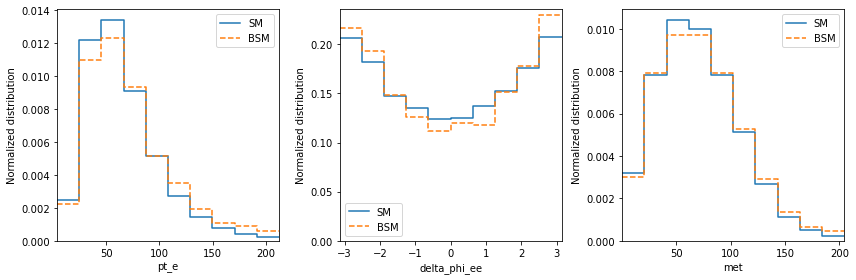

In [58]:
_ = plot_distributions(
    filename="data/lhe_data-Jonas.h5",
    parameter_points=["sm", np.array([20.0, 0.0])],
    line_labels=["SM", "BSM"],
    uncertainties="none",
    n_bins=10,
    n_cols=3,
    normalize=True,
    sample_only_from_closest_benchmark=True,
)

## 7. Combine and shuffle different samples

To reduce disk usage, you can generate several small event samples with the steps given above, and combine them now. Note that (for now) it is essential that all of them are generated with the same setup, including the same benchmark points / morphing basis!

This is generally good practice even if you use just one sample, since the events might have some inherent ordering (e.g. from sampling from different hypotheses). Later when we split the events into a training and test fraction, such an ordering could cause problems.

In [59]:
combine_and_shuffle(["data/lhe_data-Jonas.h5"], "data/lhe_data-Jonas_shuffled.h5")

16:34 madminer.sampling.co DEBUG   Combining and shuffling samples
16:34 madminer.sampling.co DEBUG   Copying setup from data/lhe_data-Jonas.h5 to data/lhe_data-Jonas_shuffled.h5
16:34 madminer.sampling.co DEBUG   Loading samples from file 1 / 1 at data/lhe_data-Jonas.h5, multiplying weights with k factor 1.0
16:34 madminer.utils.inter ERROR   HDF5 file does not contain nuisance parameters information
16:34 madminer.utils.inter ERROR   HDF5 file does not contain finite difference information
16:34 madminer.utils.inter ERROR   HDF5 file does not contain systematic information
16:34 madminer.sampling.co DEBUG   Sampling benchmarks: [3 0 0 ... 3 2 5]
16:34 madminer.sampling.co DEBUG   Combined sampling benchmarks: [3 0 0 ... 3 2 5]
16:34 madminer.sampling.co DEBUG   Recalculated event numbers per benchmark: [50000 10000 10000 10000 10000 10000], background: 0


In [5]:
import h5py
import numpy as np
setupfile = "data/lhe_data-Jonas.h5"
f = h5py.File(setupfile)
f.keys()
for key in f.keys():
    print("--------------------------------------------------------------")
    print(key+":")
    for string in np.array(f[key]):
        print("  ",string +":", np.array(f[key][string]))
    print

--------------------------------------------------------------
benchmarks:
   is_nuisance: [0 0 0 0 0 0]
   is_reference: [1 0 0 0 0 0]
   names: [b'sm' b'ctG' b'neg_ctG' b'ctq8' b'neg_ctq8' b'morphing_basis_vector_5']
   values: [[ 0.          0.        ]
 [ 1.02        0.01      ]
 [-1.04        0.02      ]
 [ 0.03        1.01      ]
 [ 0.04       -1.03      ]
 [-0.91495796 -0.91669698]]
--------------------------------------------------------------
morphing:
   components: [[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [2 0]]
   morphing_matrix: [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.15314803e-02 -5.35750913e-04  3.10871830e-02  4.97613792e-01
  -4.47454980e-01 -3.91787637e-02]
 [-9.56107755e-01 -1.67703183e-02  1.03512939e-02  4.85626580e-01
   4.70854138e-01  6.04606204e-03]
 [-2.85407760e-02  4.93762750e-01 -4.61886624e-01  1.36298214e-03
   1.22102127e-02 -1.69085449e-02]
 [ 6.26187843e-01  7.94370813e-02 -9.41135060e-01  6

In [11]:
for key in f.keys():
    print("--------------------------------------------------------------")
    print(key+":")
    for string in np.array(f[key]):
        print("  ",string +":", np.array(f[key][string]))
    print

--------------------------------------------------------------
benchmarks:
   is_nuisance: [0 0 0 0 0 0]
   is_reference: [1 0 0 0 0 0]
   names: [b'sm' b'ctG' b'neg_ctG' b'ctq8' b'neg_ctq8' b'morphing_basis_vector_5']
   values: [[ 0.          0.        ]
 [ 5.2         0.1       ]
 [-5.4         0.2       ]
 [ 0.3         5.1       ]
 [ 0.4        -5.3       ]
 [-5.5273679  -5.10043812]]
--------------------------------------------------------------
morphing:
   components: [[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [2 0]]
   morphing_matrix: [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.83624193e-02  4.99905167e-04  1.13353206e-02  9.94709020e-02
  -8.18177858e-02 -1.11259227e-02]
 [-3.63859069e-02 -1.33883732e-03  7.01816028e-04  1.88598012e-02
   1.77967872e-02  3.66339762e-04]
 [-1.19314863e-02  9.78432922e-02 -8.56930993e-02  6.88365864e-04
   3.92280552e-03 -4.82987802e-03]
 [ 3.05834823e-02  8.41354157e-04 -3.39179725e-02  1

In [34]:
print(np.array(f['samples']['sampling_benchmarks'][0:30]))

[1 0 0 1 2 0 5 0 2 3 0 5 5 2 0 0 0 2 0 0 3 1 0 0 0 3 5 4 4 1]
